# Index
1. Load libraries & Setting
2. MNIST dataset downlad
3. Model construction (___G___, ___D___)
4. Model training


## Load libraries & Setting

In [37]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms

In [2]:
# Randomness control for Reproducibility
seed = 123

random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) #if use multi-GPU
torch.manual_seed(seed)

In [3]:
# device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## MNIST dataset downlad
* batch_size : 배치 사이즈 설정

In [30]:
batch_size = 128

# MNIST dataset
transforms_mnist = transforms.Compose([transforms.ToTensor(),
                                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_loader_mnist = torch.utils.data.DataLoader(datasets.MNIST('data', train=True, download=True, transform=transforms_mnist),
                                           batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [35]:
image, label=iter(train_loader_mnist).next()

print(image.shape)
print(label.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


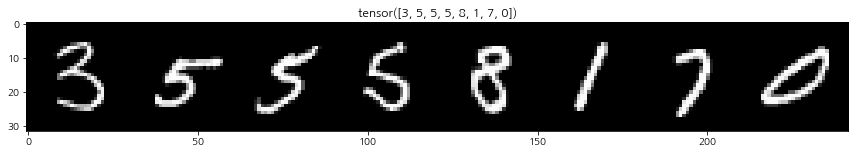

In [43]:
plt.figure(figsize= (16,2))
plt.imshow(torchvision.utils.make_grid(image[:8], normalize = True).permute(1,2,0))
plt.title(label[:8])
plt.show()

## Model construction (___G___, ___D___)

In [137]:
class generator(nn.Module):
    # initializers
    def __init__(self, input_size=28, n_class = 10):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, n_class)

    # forward method
    def forward(self, inputs):
        x = inputs.view(inputs.size(0), 100)  
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.tanh(self.fc4(x))
        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, input_size=28, n_class=10):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, n_class)

    # forward method
    def forward(self, inputs):
        x = F.leaky_relu(self.fc1(inputs), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.sigmoid(self.fc4(x))
        x = x.view(x.size(0), -1)
        return x

## Model training
* lr : 학습률(learning rate)
* train_epoch : 반복 횟수

In [144]:
lr = 0.0002
train_epoch = 100

In [145]:
G = generator(input_size=100, n_class=28*28).to(device)
D = discriminator(input_size=28*28, n_class=1).to(device)

criterion = nn.BCELoss()

g_optimizer = optim.Adam(G.parameters(), lr=lr)
d_optimizer = optim.Adam(D.parameters(), lr=lr)

In [146]:
if not os.path.exists('./model'):
    os.makedirs('./model')
if not os.path.exists('./result'):
    os.makedirs('./result')

# fixed noise for training checks
fixed_z = torch.randn((5 * 5, 100))    
with torch.no_grad():
    fixed_z = Variable(fixed_z.cuda())
fixed_z.shape

torch.Size([25, 100])

In [153]:
def show_training_proc(num_epoch, img_size, show = False, save = False, path = 'result.png', isFix=False):
    z = torch.randn((5*5, 100))
    with torch.no_grad():
        z = Variable(z.cuda())

    G.eval()
    if isFix:
        test_images = G(fixed_z)
    else:
        test_images = G(z)
    G.train()

    plt.imshow(torchvision.utils.make_grid(test_images.data.view(-1,img_size, img_size).unsqueeze(1).detach().cpu(), normalize = True, nrow = 5).permute(1,2,0), cmap='gray')
    label = 'Epoch {0}'.format(num_epoch)

    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [150]:
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

for epoch in range(train_epoch):
    D_losses = []
    G_losses = []
    for x, _ in train_loader_mnist:
        # train discriminator D
        D.zero_grad()
        x = x.view(-1, 28 * 28)
        mini_batch = x.size()[0]

        y_real = torch.ones(mini_batch)
        y_fake = torch.zeros(mini_batch)

        x, y_real, y_fake = Variable(x.cuda()), Variable(y_real.cuda()), Variable(y_fake.cuda())
        
        D_x = D(x)
        D_real_loss = criterion(D_x, y_real)
        D_real_score = D_x

        z = torch.randn((mini_batch, 100))
        z = Variable(z.cuda())
        G_z = G(z)

        D_gz = D(G_z)
        D_fake_loss = criterion(D_gz, y_fake)
        D_fake_score = D_gz

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        d_optimizer.step()

        D_losses.append(D_train_loss.item())

        # train generator G
        G.zero_grad()

        z = torch.randn((mini_batch, 100))
        y = torch.ones(mini_batch)

        z, y = Variable(z.cuda()), Variable(y.cuda())
        G_z = G(z)
        D_gz = D(G_z)
        G_train_loss = criterion(D_gz, y)
        G_train_loss.backward()
        g_optimizer.step()

        G_losses.append(G_train_loss.item())

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
          
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    
    if ((1+epoch) % 10 == 0) | (epoch==0):
        show_training_proc((epoch+1), img_size = 28, save=True, path='./result/mnist_GAN_result_{}.png'.format(epoch+1), isFix=False)
        show_training_proc((epoch+1), img_size = 28, save=True, path='./result/mnist_GAN_result_fixed_{}.png'.format(epoch+1), isFix=True)
          
torch.save(G.state_dict(), './model/G_GAN_mnist.ckpt')
torch.save(D.state_dict(), './model/D_GAN_mnist.ckpt')

[1/100]: loss_d: 1.025, loss_g: 2.553
[2/100]: loss_d: 1.217, loss_g: 1.290
[3/100]: loss_d: 1.083, loss_g: 1.558
[4/100]: loss_d: 0.841, loss_g: 2.644
[5/100]: loss_d: 0.694, loss_g: 3.490
[6/100]: loss_d: 0.788, loss_g: 2.239
[7/100]: loss_d: 0.694, loss_g: 2.401
[8/100]: loss_d: 0.671, loss_g: 2.452
[9/100]: loss_d: 0.491, loss_g: 2.890
[10/100]: loss_d: 0.522, loss_g: 2.613
[11/100]: loss_d: 0.538, loss_g: 2.675
[12/100]: loss_d: 0.530, loss_g: 2.692
[13/100]: loss_d: 0.525, loss_g: 2.744
[14/100]: loss_d: 0.634, loss_g: 2.318
[15/100]: loss_d: 0.590, loss_g: 2.553
[16/100]: loss_d: 0.625, loss_g: 2.349
[17/100]: loss_d: 0.670, loss_g: 2.228
[18/100]: loss_d: 0.706, loss_g: 2.110
[19/100]: loss_d: 0.773, loss_g: 1.963
[20/100]: loss_d: 0.812, loss_g: 1.918
[21/100]: loss_d: 0.764, loss_g: 1.992
[22/100]: loss_d: 0.785, loss_g: 1.886
[23/100]: loss_d: 0.796, loss_g: 1.887
[24/100]: loss_d: 0.859, loss_g: 1.734
[25/100]: loss_d: 0.834, loss_g: 1.786
[26/100]: loss_d: 0.869, loss_g: 1

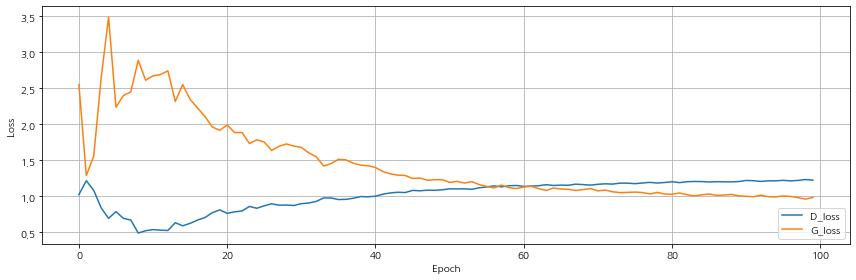

In [166]:
x = range(len(train_hist['D_losses']))

y1 = train_hist['D_losses']
y2 = train_hist['G_losses']
plt.figure(figsize= (12,4))
plt.plot(x, y1, label='D_loss')
plt.plot(x, y2, label='G_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend(loc=4)
plt.grid(True)
plt.tight_layout()
plt.show()